Lab
==========================
Regression and Regularization


##### Installation instructions:       

In [1]:
# describing statistical models and building design matrices
!pip install patsy

In [2]:
# explore data, estimate statistical models, and perform statistical tests
!pip install statsmodels

!pip install seaborn

In [14]:
%matplotlib inline

from __future__ import division

import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
from seaborn import plt

this dataset shows a set of six numeric survey responses $X_i$ (survey responses)  
and a dependent variable $Y$ (perceived supervisor quality)  
we want to predict $Y$ from the $X$'s 

In [7]:
x = pd.read_table('http://www.ats.ucla.edu/stat/examples/chp/p054.txt')
x.head()
x.tail()

,Y,X1,X2,X3,X4,X5,X6
25,66,77,66,63,88,76,72
26,78,75,58,74,80,78,49
27,48,57,44,45,51,83,38
28,85,85,71,71,77,74,55
29,82,82,39,59,64,78,39


In [25]:
print x.columns
print x.shape

Index([u'Y', u'X1', u'X2', u'X3', u'X4', u'X5', u'X6'], dtype='object')
(30, 7)


the column names have trailing whitespace, so I fix that by mapping `str.strip` onto the `columns`' names.

In [26]:
x.columns = x.columns.map(str.strip)

In [10]:
x.columns

Index([u'Y', u'X1', u'X2', u'X3', u'X4', u'X5', u'X6'], dtype='object')

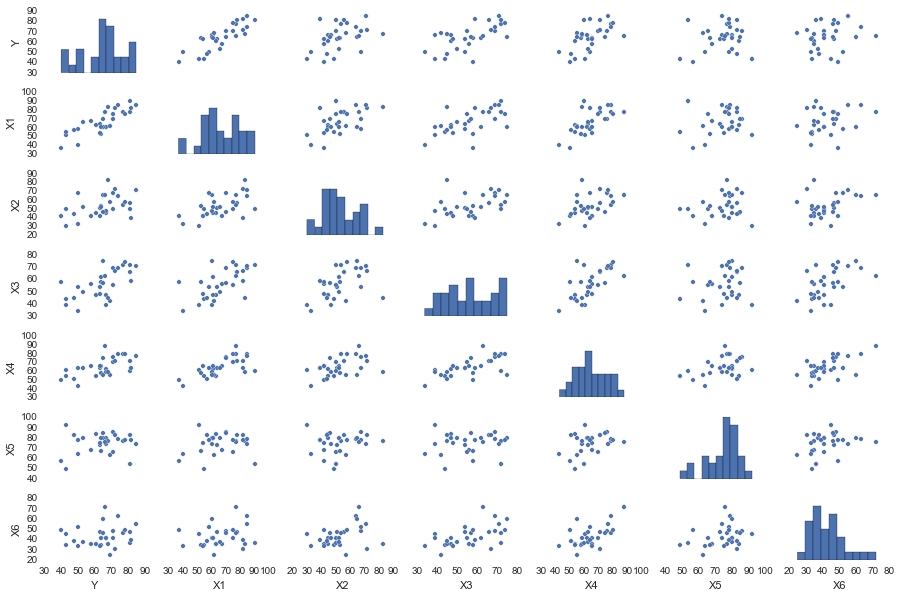

In [11]:
sns.pairplot(x, size = 1.2, aspect=1.5)

In [27]:
lm = smf.ols('Y ~ X1 + X2 + X3 + X4 + X5 + X6', data=x)
fit = lm.fit()
print fit.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Tue, 19 May 2015   Prob (F-statistic):           1.24e-05
Time:                        19:21:10   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.7871     11.589      0.931      0.3

remove feature w/ lowest (abs) t score

In [11]:
fit2 = smf.ols('Y ~ X1 + X2 + X3 + X4 + X6', data=x).fit()
print fit2.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     13.10
Date:                Tue, 19 May 2015   Prob (F-statistic):           3.28e-06
Time:                        18:54:32   Log-Likelihood:                -97.294
No. Observations:                  30   AIC:                             206.6
Df Residuals:                      24   BIC:                             215.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     12.7979      8.491      1.507      0.1

###note R-sq decreases slightly, but adj R-sq increases slightly
The adjusted R2 will penalize you for adding independent variables that do not fit the model. 

--> increasing bias, decreasing variance

In [12]:
fit4 = smf.ols('Y ~ X1 + X3 + X6', data=x).fit()
print fit4.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     22.92
Date:                Tue, 19 May 2015   Prob (F-statistic):           1.81e-07
Time:                        18:54:32   Log-Likelihood:                -97.638
No. Observations:                  30   AIC:                             203.3
Df Residuals:                      26   BIC:                             208.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     13.5777      7.544      1.800      0.0

$\rightarrow$ optimal bias-variance point reached

In [13]:
fit5 = smf.ols('Y ~ X1 + X3', data=x).fit()
print fit5.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     32.74
Date:                Tue, 19 May 2015   Prob (F-statistic):           6.06e-08
Time:                        18:54:33   Log-Likelihood:                -98.569
No. Observations:                  30   AIC:                             203.1
Df Residuals:                      27   BIC:                             207.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      9.8709      7.061      1.398      0.1

note this model is weaker (lower $Adj. R^2$)

want to see absence of structure in resid scatterplot ("gaussian white noise")

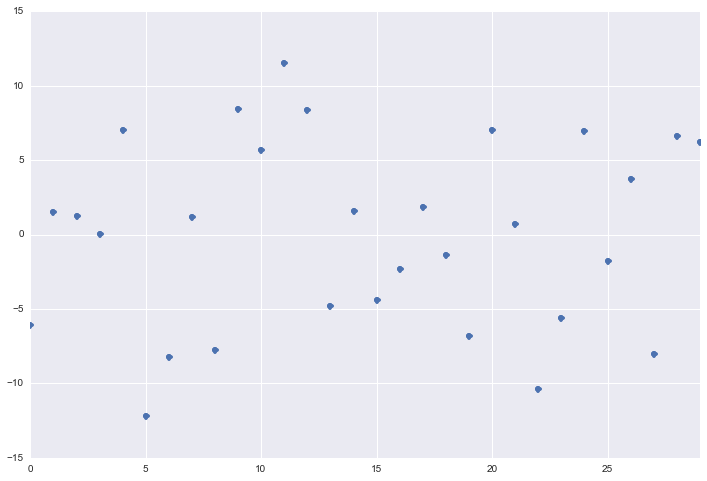

In [14]:
fit4.resid.plot(style='o', figsize=(12,8)) #chart residuals

[a bad residue plot](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit)

# Polynomial and Regularized Regression
First, credits: many of the examples used come from the brilliant [Peter Prettenhofer](https://twitter.com/pprett) of [DataRobot](http://www.datarobot.com/).<br><br>
Second, housekeeping: You may need to update scikit:<br>
`$ conda update scikit-learn`<br><br>
`$ pip update scikit-learn`<br><br>
Third, let's take a minute to discuss [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) and [`make_pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

## Polynomial Regression
[Polynomial regression](http://en.wikipedia.org/wiki/Polynomial_regression) fits a n-th order polynomial to our data using least squares. 
[Linear regression](http://en.wikipedia.org/wiki/Linear_regression) is a special case of polynomial regression which fits a polynomial of degree=1.<br>
To illustrate:

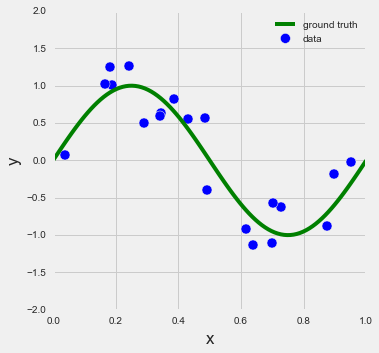

In [43]:
%matplotlib inline

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.cross_validation import train_test_split
import matplotlib.pylab as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from IPython.core.pylabtools import figsize
figsize(5,5)
plt.style.use('fivethirtyeight')

np.random.seed(9)

def f(x):
    return np.sin(2 * np.pi * x)

# generate points used to plot
x_plot = np.linspace(0, 1, 100)

# generate points and keep a subset of them
n_samples = 100
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

fig,ax = plt.subplots(1,1)
ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
ax.scatter(X_train, y_train, label='data', s=100)
ax.set_ylim((-2, 2))
ax.set_xlim((0, 1))
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

###Q: Is there a *LINE* that best approximates our data?

In [17]:
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X_train, y_train, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

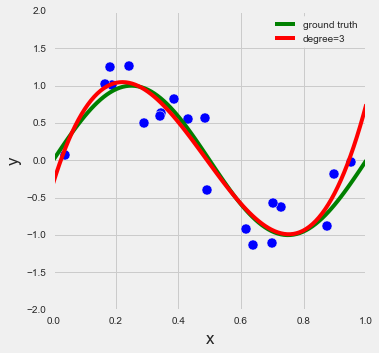

In [18]:
fig,ax = plt.subplots(1,1)
degree = 3
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
est.fit(X_train, y_train)
plot_approximation(est, ax, label='degree=%d' % degree)

###Q: Qualitatively, how would you characterize this fit?

##Your turn:
Plot the fit of a polynomial of degree 2:

In [19]:
make_pipeline?

Plot the fit of a polynomial of degree 3:

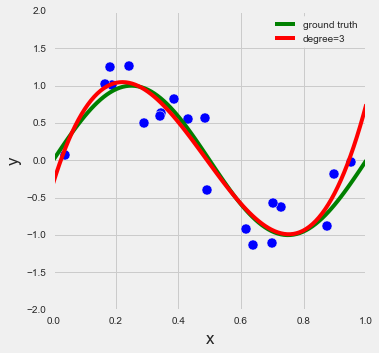

In [30]:
fig,ax = plt.subplots(1,1)
degree = 3
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
est.fit(X_train, y_train)
plot_approximation(est, ax, label='degree=%d' % degree)

Plot the fit of a polynomial of degree 9:

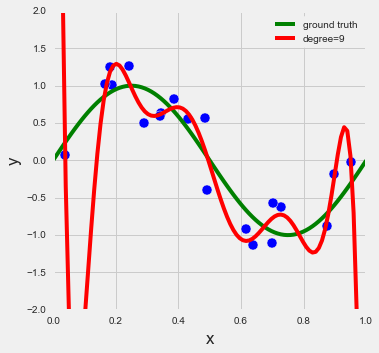

In [31]:
fig,ax = plt.subplots(1,1)
degree = 9
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
est.fit(X_train, y_train)
plot_approximation(est, ax, label='degree=%d' % degree)

###Q: What happens as we increase the degree of polynomial?

###Q: Which polynomial should we choose? 

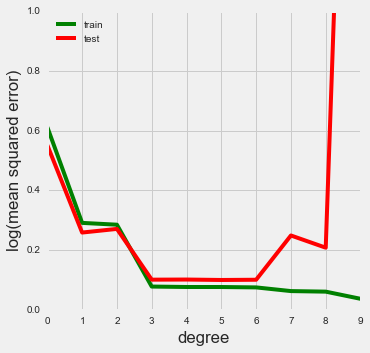

In [20]:
from sklearn.metrics import mean_squared_error

train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 1e0))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left')

The higher the degree of the polynomial (our proxy for model complexity), the lower the training error. The testing error decreases too, but it eventually reaches its minimum at a degree of three and then starts increasing at a degree of seven. 

This phenomenon is called *overfitting*: the model is already so complex that it fits the idiosyncrasies of our training data, idiosyncrasies which limit the model's ability to generalize (as measured by the testing error).

In the above example, the optimal choice for the degree of the polynomial approximation would be between three and six. So when we get some data, we could fit a bunch of polynomials and then choose the one that minimizes MSE.

###Hand picking polynomials is hard work, and data scientists are lazy so....
...we would like a method that eliminates the need to manually select the degree of the polynomial: we can add a constraint to our linear regression model that constrains the magnitude of the coefficients in the regression model. This constraint is called the regularization term and the technique is often called shrinkage in the statistical community because it shrinks the coefficients towards zero. In the context of polynomial regression, constraining the magnitude of the regression coefficients effectively is a smoothness assumption: by constraining the L2 norm of the regression coefficients we express our preference for smooth functions rather than wiggly functions.

A popular regularized linear regression model is Ridge Regression. This adds the L2 norm of the coefficients to the ordinary least squares objective:

  $J(\boldsymbol\beta) = \frac{1}{n}\sum_{i=0}^n (y_i - \boldsymbol\beta^T \mathbf{x}_i')^2 + \alpha \|\boldsymbol\beta\|_2$

where $\boldsymbol\beta$ is the vector of coefficients including the intercept term and $\mathbf{x}_i'$ is the i-th feature fector including a dummy feature for the intercept. The L2 norm term is weighted by a regularization parameter ``alpha``: if ``alpha=0`` then you recover the Ordinary Least Squares regression model. The larger the value of ``alpha`` the higher the smoothness constraint.

Below you can see the approximation of a [``sklearn.linear_model.Ridge``](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) estimator fitting a polynomial of degree nine for various values of ``alpha`` (left) and the corresponding coefficient loadings (right). The smaller the value of ``alpha`` the higher the magnitude of the coefficients, so the functions we can model can be more and more wiggly. 

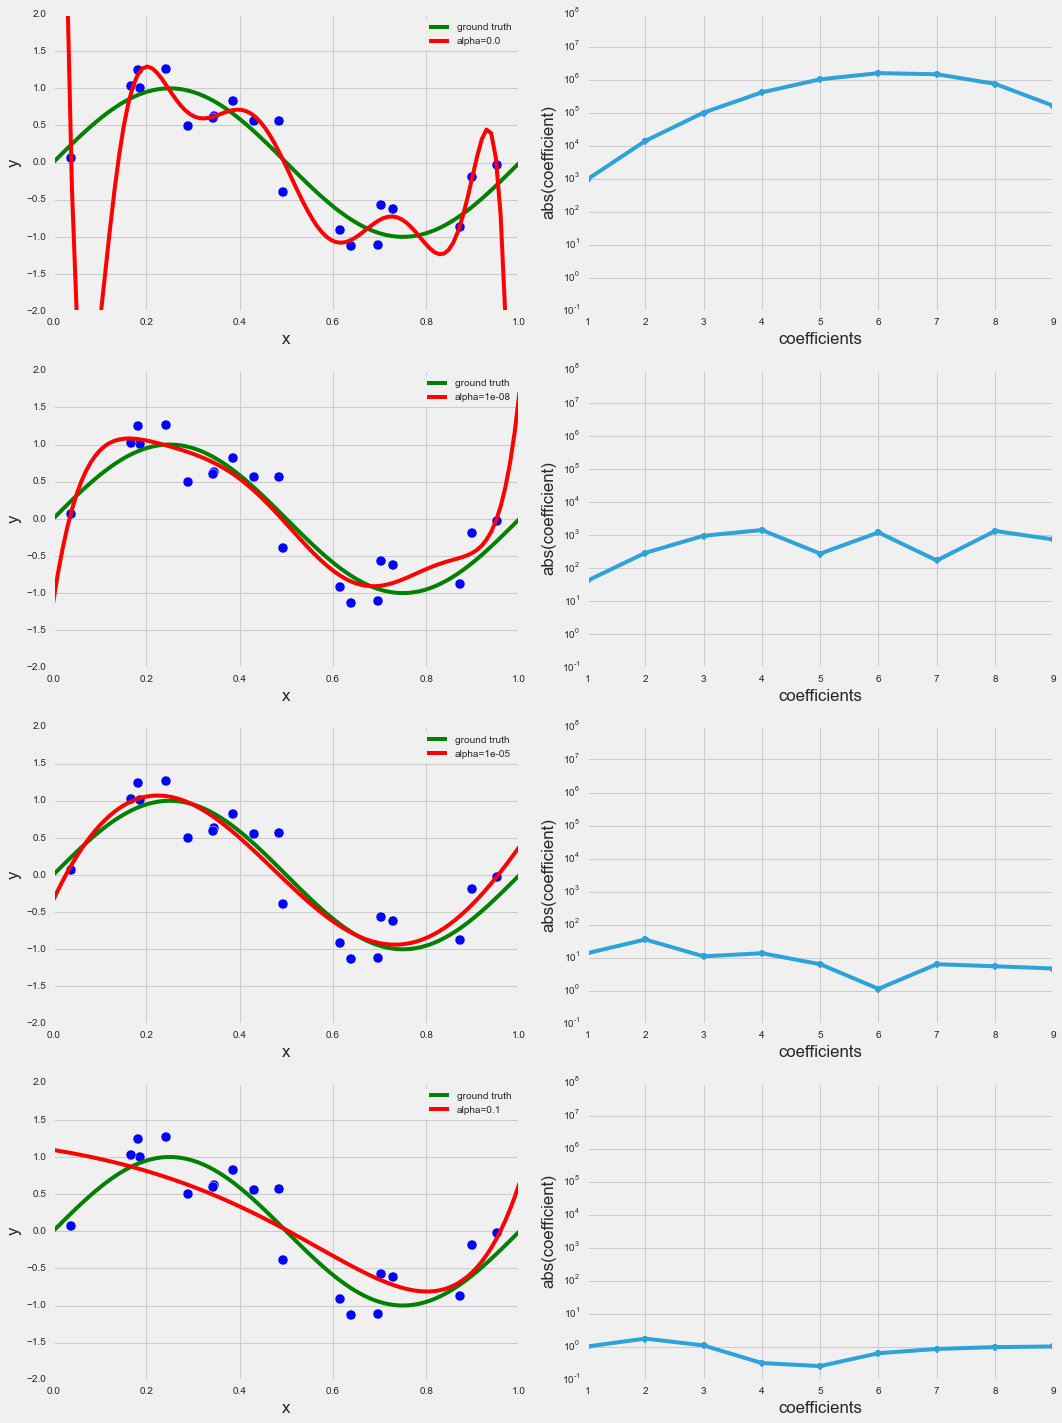

In [21]:
fig, ax_rows = plt.subplots(4, 2, figsize=(15, 20))

def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((1, 9))

degree = 9
alphas = [0.0, 1e-8, 1e-5, 1e-1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)

plt.tight_layout()

## Regularization techniques

In the above example we used Ridge Regression, a regularized linear regression technique that puts an [L2 norm](http://mathworld.wolfram.com/L2-Norm.html) penalty on the regression coefficients. Another popular regularization technique is the LASSO, a technique which puts an [L1 norm](http://mathworld.wolfram.com/L1-Norm.html) penalty instead. The difference between the two is that the LASSO leads to sparse solutions, driving most coefficients to zero, whereas Ridge Regression leads to dense solutions, in which most coefficients are non-zero.

/Library/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:490: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


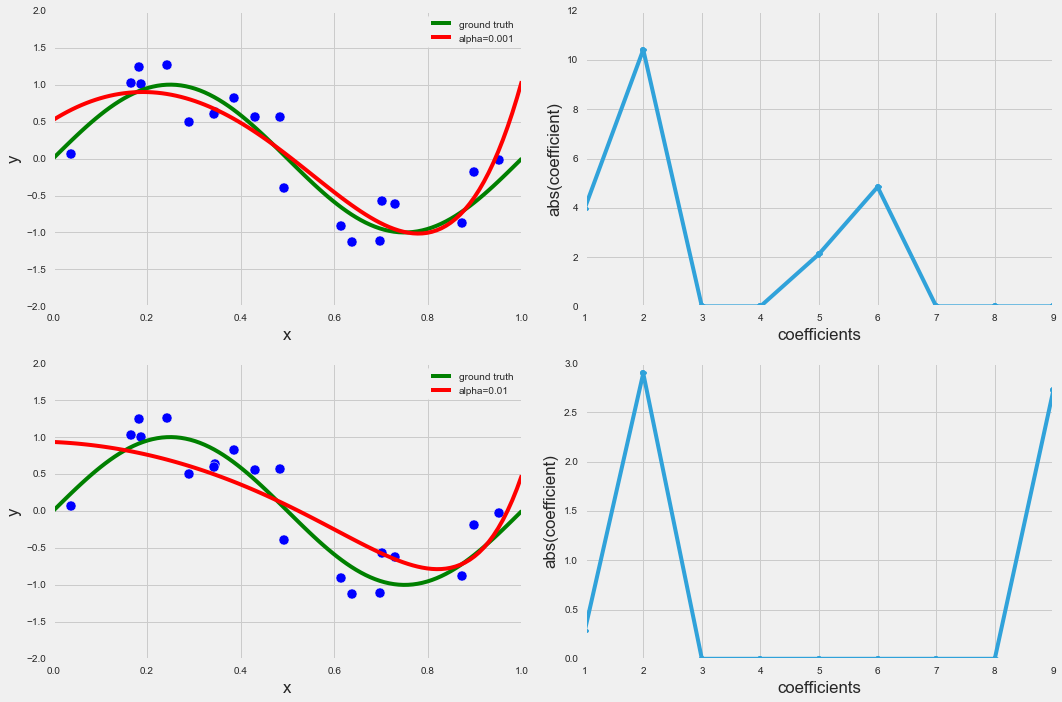

In [22]:
from sklearn.linear_model import Lasso

fig, ax_rows = plt.subplots(2, 2, figsize=(15, 10))

degree = 9
alphas = [1e-3, 1e-2]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Lasso(alpha=%r) coefficients' % alpha, yscale=None)

plt.tight_layout()

##Further Exercises


A criminologist studying the relationship between income level and assults in U.S. cities (among other things) collected the following data for 2215 communities. The dataset can be found in the [UCI machine learning site](http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized).

We are interested in the per capita assult rate and its relation to median income.

In [16]:
crime = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/00211/CommViolPredUnnormalizedData.txt", 
                    header = None, na_values  = '?',
                    names = ['communityname', 'state', 'countyCode', 'communityCode', 'fold', 'population', 'householdsize', 
                             'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 
                             'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 
                             'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 
                             'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 
                             'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 
                             'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 
                             'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 
                             'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumKidsBornNeverMar', 
                             'PctKidsBornNeverMar', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 
                             'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 
                             'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 
                             'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 
                             'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 
                             'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 
                             'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccHiQuart', 'OwnOccQrange', 'RentLowQ', 'RentMedian', 
                             'RentHighQ', 'RentQrange', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 
                             'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 
                             'PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 
                             'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 
                             'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 
                             'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 
                             'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg', 
                             'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop', 
                             'murders', 'murdPerPop', 'rapes', 'rapesPerPop', 'robberies', 'robbbPerPop', 'assaults', 
                             'assaultPerPop', 'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop', 'autoTheft', 
                             'autoTheftPerPop', 'arsons', 'arsonsPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop'])

1. Fit a simple linear regression model to the data with `np.log(crime.assaults)` as the dependent variable and `np.log(crime.medIncome)` as the independent variable. Plot the estimated regression line.

4. Test whether there is a linear relationship between `assaults` and `medIncome` at level $\alpha=0.05$. State the null hypothesis, the alternative, the conclusion and the $p$-value.

5. Give a 95% confidence interval for the slope of the regression line. Interpret your interval.

6. Report the $R^2$ and the adjusted $R^2$ of the model, as well as an estimate of the variance of the errors in the model.

7. Go to [archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized](http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized) and pick out a few other factors that might help you predict `assults`.

In [24]:
print crime.describe()

       countyCode  communityCode         fold      population  householdsize  \
count  994.000000     991.000000  2215.000000     2215.000000    2215.000000   
mean    65.587525   45209.251261     5.494357    53117.984199       2.707327   
std    117.831399   25425.861573     2.872924   204620.252853       0.334120   
min      1.000000      70.000000     1.000000    10005.000000       1.600000   
25%     11.000000   22887.000000     3.000000    14366.000000       2.500000   
50%     27.000000   46925.000000     5.000000    22792.000000       2.660000   
75%     80.500000   65805.000000     8.000000    43024.000000       2.850000   
max    840.000000   94597.000000    10.000000  7322564.000000       5.280000   

       racepctblack  racePctWhite  racePctAsian  racePctHisp  agePct12t21  \
count   2215.000000   2215.000000   2215.000000  2215.000000  2215.000000   
mean       9.335102     83.979819      2.670203     7.950176    14.445837   
std       14.247156     16.419080      4.473843 

In [ ]:
#sns.pairplot(crime, size = 1.2, aspect=1.5)

Fit a simple linear regression model to the data with np.log(crime.assaults) as the dependent variable and np.log(crime.medIncome) as the independent variable. Plot the estimated regression line.

In [30]:
crime['Y'] = np.log(crime.assaults)
crime ['X'] =  np.log(crime.medIncome)
print crime.describe()

       countyCode  communityCode         fold      population  householdsize  \
count  994.000000     991.000000  2215.000000     2215.000000    2215.000000   
mean    65.587525   45209.251261     5.494357    53117.984199       2.707327   
std    117.831399   25425.861573     2.872924   204620.252853       0.334120   
min      1.000000      70.000000     1.000000    10005.000000       1.600000   
25%     11.000000   22887.000000     3.000000    14366.000000       2.500000   
50%     27.000000   46925.000000     5.000000    22792.000000       2.660000   
75%     80.500000   65805.000000     8.000000    43024.000000       2.850000   
max    840.000000   94597.000000    10.000000  7322564.000000       5.280000   

       racepctblack  racePctWhite  racePctAsian  racePctHisp  agePct12t21  \
count   2215.000000   2215.000000   2215.000000  2215.000000  2215.000000   
mean       9.335102     83.979819      2.670203     7.950176    14.445837   
std       14.247156     16.419080      4.473843 

In [32]:
crime[crime.Y.isnull()]

,communityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop,Y,X
223,Laurelcity,MS,NaN,NaN,2,18827,2.59,48.10,51.62,0.16,...,1179,6027.61,104,531.70,8,40.90,NaN,8890.59,NaN,9.740792
296,Lancastercity,OH,45,41720,2,34507,2.47,0.51,98.75,0.38,...,1184,3329.02,60,168.70,0,0.00,NaN,4127.54,NaN,10.018155
358,UniversalCitycity,TX,NaN,NaN,2,13057,2.67,5.81,85.86,2.42,...,433,3116.68,28,201.54,2,14.40,NaN,3879.65,NaN,10.480522
436,Dumascity,TX,NaN,NaN,2,12871,2.88,0.65,76.89,2.11,...,NaN,NaN,1,7.21,0,0.00,NaN,NaN,NaN,10.286162
539,Allencity,TX,NaN,NaN,3,18309,3.11,3.25,93.18,1.17,...,497,1794.29,38,137.19,3,10.83,NaN,2480.23,NaN,10.776223
727,Worcestercity,MA,27,82000,4,169759,2.66,4.52,87.08,2.81,...,5221,3139.70,1692,1017.50,NaN,NaN,NaN,NaN,NaN,10.273498
818,Houstoncity,TX,NaN,NaN,4,1630553,2.64,28.09,52.69,4.12,...,61569,3550.01,27519,1586.72,1549,89.31,NaN,6784.10,NaN,10.175840
836,Fairfieldtown,CT,1,26620,4,53418,2.76,0.82,97.60,1.26,...,1180,2176.00,378,697.06,4,7.38,NaN,3813.53,NaN,10.928669
1378,Garlandcity,TX,NaN,NaN,7,180650,2.86,8.87,79.67,4.47,...,7567,3824.13,1033,522.05,145,73.28,NaN,5694.00,NaN,10.526051
1627,Akroncity,OH,153,1000,8,223019,2.48,24.51,73.76,1.21,...,8675,3892.51,2043,916.70,190,85.25,NaN,6405.25,NaN,10.011400


In [37]:
#remove nulls
crime_no_nulls = crime[crime.Y.notnull()]
crime_no_nulls.describe()

,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop,Y,X
count,988.000000,985.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,...,2200.000000,2200.000000,2199.000000,2199.000000,2113.000000,2113.000000,1994.000000,2108.000000,2202.000000,2202.000000
mean,65.740891,45254.353299,5.497275,52142.296094,2.707230,9.322593,84.006426,2.671748,7.928642,14.446176,...,2102.786364,3373.660959,501.341064,472.263183,30.128727,32.148050,589.078922,4907.316822,-inf,10.363721
std,118.101401,25393.624694,2.872774,202312.313665,0.334772,14.248111,16.422696,4.483233,14.606341,4.531198,...,7510.675180,1904.833777,3214.798999,502.951811,177.484684,39.273465,614.784518,2743.134531,NaN,0.370128
min,1.000000,70.000000,1.000000,10005.000000,1.600000,0.000000,2.680000,0.030000,0.120000,4.580000,...,10.000000,77.860000,1.000000,6.550000,0.000000,0.000000,0.000000,116.790000,-inf,9.089979
25%,11.000000,22960.000000,3.000000,14359.250000,2.500000,0.860000,76.375000,0.620000,0.930000,12.250000,...,391.000000,2038.175000,30.000000,156.655000,1.000000,7.670000,161.700000,2915.402500,2.890372,10.078113
50%,27.000000,47042.000000,5.000000,22769.000000,2.660000,2.860000,90.380000,1.230000,2.165000,13.620000,...,743.500000,3077.390000,74.000000,301.120000,5.000000,21.110000,374.060000,4425.450000,4.025352,10.355979
75%,81.000000,65790.000000,8.000000,42510.500000,2.850000,11.117500,96.230000,2.670000,7.742500,15.357500,...,1664.500000,4340.895000,229.500000,587.985000,16.000000,42.840000,794.400000,6227.360000,5.192957,10.633220
max,840.000000,94597.000000,10.000000,7322564.000000,5.280000,96.670000,99.630000,57.460000,95.290000,54.400000,...,235132.000000,25910.550000,112464.000000,4968.590000,5119.000000,436.370000,4877.060000,27119.760000,11.047360,11.725008


In [77]:
# remove infinite numbers
crime2= crime_no_nulls[np.isfinite(crime_no_nulls.Y)]
print crime2['X'].describe()
print crime2['Y'].describe()

count    2184.000000
mean       10.363173
std         0.369919
min         9.089979
25%        10.076011
50%        10.355120
75%        10.633256
max        11.725008
Name: X, dtype: float64
count    2184.000000
mean        4.117103
std         1.670503
min         0.000000
25%         2.944439
50%         4.051747
75%         5.198497
max        11.047360
Name: Y, dtype: float64


In [64]:
fit_0 = smf.ols('Y ~ X', data=crime2).fit()
print fit_0.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     371.8
Date:                Tue, 19 May 2015   Prob (F-statistic):           1.24e-76
Time:                        20:10:14   Log-Likelihood:                -4047.3
No. Observations:                2184   AIC:                             8099.
Df Residuals:                    2182   BIC:                             8110.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     21.9740      0.927     23.713      0.0

In [87]:
print type(crime2.X.values)

<type 'numpy.ndarray'>


In [88]:
print crime2.X.shape
fit_predicted = fit_0.predict(crime2.X)
print len(fit_predicted)

(2184,)
100


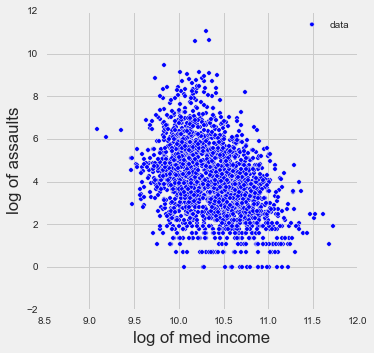

In [69]:
fig,ax = plt.subplots(1,1)
#ax.plot(crime_no_inf.X, income_assault.predict(crime_no_inf.X), label='regression', color='green')
ax.scatter(crime_no_inf.X, crime_no_inf.Y, label='data', s=20)
ax.set_ylabel('log of assaults')
ax.set_xlabel('log of med income')
ax.legend()